# WISERCLUB
### 2019-2020 Final
### Author:王梓鉴 (Wang Zijian)

#### Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
# deal with some cells that reqiure a large memory（sometimes encounter memory error on local computer） by colab
# from google.colab import drive 
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive

In [80]:
#read from local computer
data = pd.read_csv('data.csv') 
df = pd.read_csv('data.csv')
holiday = pd.read_csv('holiday.csv')
# #read from google drive
# data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data.csv') 
# df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351855 entries, 0 to 2351854
Data columns (total 15 columns):
Unnamed: 0                 int64
Unnamed: 0.1               int64
dt                         object
phone_no                   int64
member_id                  int64
commodity_code             object
commodity_name             object
commodity_origin_money     float64
coupon_id                  float64
coupon_money               float64
one_category_name          object
two_category_name          object
commodity_income           float64
pay_money                  float64
coffeestore_share_money    float64
dtypes: float64(6), int64(4), object(5)
memory usage: 269.1+ MB


In [182]:
# seeing that the dtype of dt is obeject
df['dt'] = pd.to_datetime(df['dt']).dt.date

print ('timespan is from', df['dt'].min(), 'to', df['dt'].max())

timespan is from 2019-01-20 to 2019-03-01


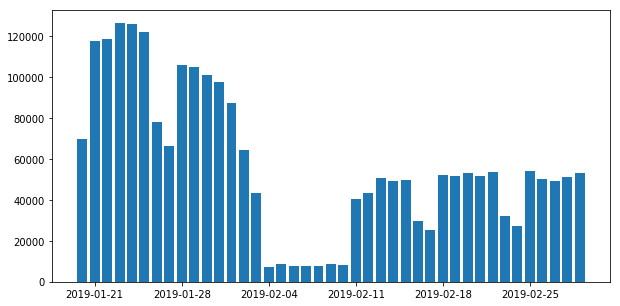

In [183]:
count = df['dt'].value_counts()
count = pd.DataFrame(count)
plt.figure(figsize = (10 , 5))
plt.bar(count.index.values , np.array(count['dt']))
plt.show()

In [35]:
#seeing that the variation of the orders has a period of 7days,now count the number of weekdays and weekends
count['week'] = 0
for i in range(len(count)):
    count.iloc[i, 1] = count.index.values[i].isoweekday()

In [36]:
print(len(count))

41


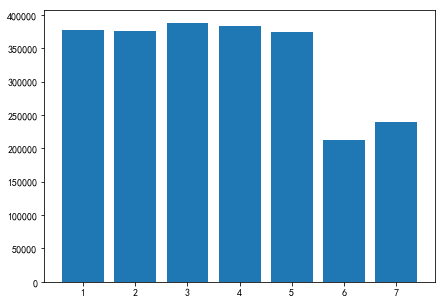

In [37]:
# seeing that the data almost 6 compelet weeks
week = count.groupby(['week']).sum()
week = pd.DataFrame(week)
plt.figure(figsize = (7, 5))
plt.bar(week.index.values, np.array(week['dt']))
plt.show()

we do need to design two different strategies for sales in workdays and sales in weekends.

In [38]:
print('the number of users is', len(data.groupby(['member_id']).count()))

the number of users is 466886


In [39]:
product = data.groupby(['commodity_name']).count()
top = product.sort_values('Unnamed: 0.1', ascending = False)
print(top.head(10).index.values)

['拿铁' '榛果拿铁' '澳瑞白' '标准美式' '香草拿铁' '卡布奇诺' '摩卡' '加浓美式' '焦糖玛奇朵' '焦糖拿铁']


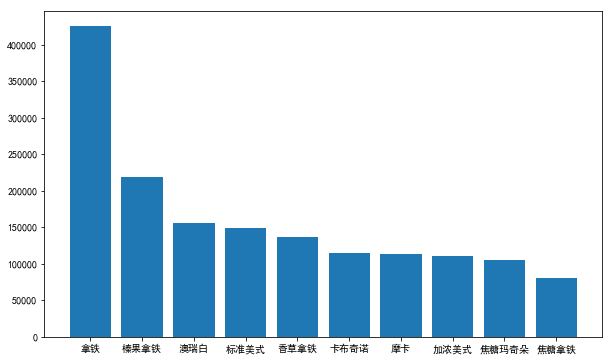

In [40]:
font = {'family' : 'SimHei',
        'weight' : 'normal',
        'size'  : '10'}
plt.rc('font', **font)        
plt.rc('axes', unicode_minus=False)
plt.figure(figsize=(10,6))
plt.bar(top.head(10).index.values, top['Unnamed: 0.1'][:10])
plt.show()

In [48]:
commodity_income = np.array(data['commodity_income'])
commodity_origin_money = np.array(data['commodity_origin_money'])
discount_rate = commodity_income / commodity_origin_money

discount_rate = pd.DataFrame(discount_rate.T, columns = ['discount_rate'])

data = pd.concat([data, discount_rate], axis=1, join='outer')

In [42]:
day_discount = pd.DataFrame(np.zeros(shape = (len(count), 2)))

In [43]:
print(count.sort_index().head(3))
print(count.sort_index().tail(3))

                dt  week
2019-01-20   69859     7
2019-01-21  117686     1
2019-01-22  118409     2
               dt  week
2019-02-27  48970     3
2019-02-28  51272     4
2019-03-01  53279     5


the last week is not a compelete week.

In [44]:
day_mean = data.groupby(['dt']).mean()

week_discount = []
for i in range(int(len(day_mean) / 7) +1):
    if len(day_discount) - i - 1 <7:
        week_discount.append(day_mean[i:len(day_discount) - 1]['discount_rate'].mean())
        break
    week_discount.append(day_mean[i:i+7]['discount_rate'].mean())


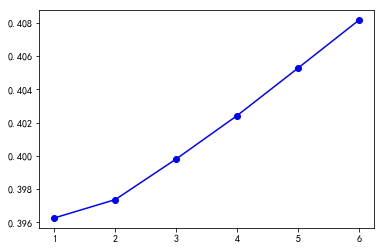

In [45]:
plt.figure(figsize = (6 ,4))
plt.plot(range(1 ,len(week_discount) +1), week_discount, 'bo-')
plt.show()

In [46]:
# def day_retention_rate(year, month, day, data):
#     """
#     required month's and day's type does NOT include 0 before the number
#     """
#     date = datetime.date(year, month, day)
#     total_num = data.groupby(['dt']).count().loc[date,'Unnamed: 0']
#     two_day_data = data[data['dt'].isin([date, date + datetime.timedelta(-1)])]
#     A = two_day_data.groupby(['member_id']).count()
#     retention_num = len(A.loc[A['Unnamed: 0'] >= 2])
#     return retention_num / total_num

#considering that many members buy the commodity over ONE time per day 
def day_retention_rate(year, month, day, data):
    """
    required month's and day's type does NOT include 0 before the number
    """
    date = datetime.date(year, month, day)
    today = data[data['dt'].isin([str(date)])]
    today_num = len(today.groupby(['member_id']).count())
    tomorrow = data[data['dt'].isin([str(date + datetime.timedelta(1))])]
    retention = tomorrow[tomorrow.isin(today.groupby(['member_id']).count().index.values)]
    retention_num = len(retention.groupby(['member_id']).count())
    
    return retention_num / today_num

In [47]:
day_retention_rate(2019, 2, 9, data)

0.06983429151166723

In [48]:
def week_retention_rate(year, month, day, data):
    """
    required month's and day's type does NOT include 0 before the number
    """
    date = datetime.date(year, month, day)
    today = data[data['dt'].isin([str(date)])]
    today_num = len(today.groupby(['member_id']).count())
    week = [str(date + datetime.timedelta(i)) for i in range(1,8)]
    next_week = data[data['dt'].isin(week)]
    retention = next_week[next_week.isin(today.groupby(['member_id']).count().index.values)]
    retention_num = len(retention.groupby(['member_id']).count())
    
    return retention_num / today_num

In [49]:
week_retention_rate(2019, 2, 9, data)

0.3371660466689212

In [50]:
def new_users_week_retention_rate(year, month, day, data):
    """
    required month's and day's type does NOT include 0 before the number
    """
    date = datetime.date(year, month, day)
    
    begin = pd.to_datetime(data['dt']).dt.date.min()
    before = [str(begin + datetime.timedelta(i)) for i in range(int(str(date - begin)[0]))]
    old = data[data['dt'].isin(before)]
    old_users = old.groupby(['member_id']).count().index.values
    today = data[data['dt'].isin([str(date)])]
    today_users = today.groupby(['member_id']).count().index.values
    
    #find member id in today_users and not in old_users   reference:https://cloud.tencent.com/developer/ask/31557
    new_users_index = np.where(pd.Index(old_users).get_indexer(today_users) >= 0)[0]  #返回A中B也含有的元素在A中的索引值（从0开始）
    new_users = np.delete(today_users, new_users_index)
    
    week = [str(date + datetime.timedelta(i)) for i in range(1,8)]
    next_week = data[data['dt'].isin(week)]
    
    retention = next_week[next_week['member_id'].isin(new_users)]
    retention_num = retention.groupby(['member_id']).count().index.values.size
    
    return retention_num / len(new_users)

In [51]:
new_users_week_retention_rate(2019, 2, 9, data)

0.2741032552353307

In [52]:
def first_day_of_week(date):
    return date - datetime.timedelta(date.isoweekday()-1)
def week_list(date):
    first_day = first_day_of_week(date)
    week_date = [str(first_day + datetime.timedelta(i)) for i in range(7)]
    
    return week_date
def one_week_new_uesers_retention_rate(year, month, day, data):
    """
    required month's and day's type does NOT include 0 before the number
    caculate the week of the given date
    """
    date = datetime.date(year, month, day)
    week_date = week_list(date)
    week = data[data['dt'].isin(week_date)]
    week_users = week.groupby(['member_id']).count().index.values
    
    begin = pd.to_datetime(data['dt']).dt.date.min()
    before = [str(begin + datetime.timedelta(i)) for i in range(int(str(first_day_of_week(date) - begin)[0]))]
    old = data[data['dt'].isin(before)]
    old_users = old.groupby(['member_id']).count().index.values

    new_users_index = np.where(pd.Index(old_users).get_indexer(week_users) >= 0)[0]
    new_users = np.delete(week_users, new_users_index)

    retention = week[week['member_id'].isin(new_users)].groupby(['member_id']).count()
    retention_num = len(retention[retention['Unnamed: 0'] >= 2])
    
    return retention_num / len(new_users)

In [53]:
one_week_new_uesers_retention_rate(2019, 2, 9, data)

0.3753129863977803

In [54]:
user = data.groupby(['member_id']).count()
active_user = user[user['Unnamed: 0'] >= 5]

active_user = pd.DataFrame(active_user.loc[:,'Unnamed: 0'])
active_user.columns = ['amount']

In [55]:
print(active_user.describe())

              amount
count  166308.000000
mean       10.418188
std         7.599244
min         5.000000
25%         6.000000
50%         8.000000
75%        12.000000
max       585.000000


In [56]:
active_user.to_csv('ActiveUser.csv')

#### Part 2

In [81]:
data = data.drop(data.columns[0], axis=1)

In [6]:
#the memory usage is too large though on colab, so caculate 1 million pieces of data individually
user_item1 = pd.pivot_table(user_item[0 : 1000000], index = 'phone_no', columns = 'commodity_name', aggfunc = np.count_nonzero, fill_value = 0) 
# user_item2 = pd.pivot_table(user_item[1000001 : 2000000], index = 'phone_no', columns = 'commodity_name', aggfunc = np.count_nonzero, fill_value = 0)
# user_item3 = pd.pivot_table(user_item[2000001 : len(data)], index = 'phone_no', columns = 'commodity_name', aggfunc = np.count_nonzero, fill_value = 0)  

In [82]:
#or on local computer: delete other unused columns
user_item = pd.concat([data['phone_no'], data['commodity_name']], axis=1, join='outer')
user_item_table = pd.pivot_table(user_item, index = 'phone_no', columns = 'commodity_name', aggfunc = np.count_nonzero, fill_value = 0)

In [8]:
user_item1.memory_usage().sum() #a quarter of the whole dataset

186260960

In [9]:
user_item_table.memory_usage().sum() # the whole dataset

276396512

I want to have a taste of 灌汤包, NFC鲜榨荔枝汁 and 虾仁炒饭 in luckin. jpg

In [ ]:
user_date = pd.concat([data['phone_no'], data['dt']], axis=1, join='outer')
user_date_table = pd.pivot_table(user_date, index = 'phone_no', columns = 'dt', aggfunc = np.count_nonzero, fill_value = 0)

print(user_date_table.columns)

In [ ]:
# saving the variables
from sklearn.externals import joblib
# save
joblib.dump(user_date_table, 'table.pkl') 

In [ ]:
# imoprt
table = joblib.load('table.pkl')

#### Part 3 & Part 2.3(partly)

In [147]:
#The time span is 41 days, so omit the last day, 2019-03-01. That means taking the first 40 days as features and the 41st day as the target.
A = np.array(user_date_table)
dataset = (A[:,0] + A[:,1]).reshape(len(A),1)
for i in range(1,20):
    dataset = np.column_stack([dataset, (A[:, 2 * i] + A[:, 2 * i +1]).reshape(len(A),1)])

a = np.where(A[:,40])
y = np.zeros(len(A))
for i in a:
    y[i] = 1

In [148]:
X = np.array(dataset)
Y = np.array(y)

In [2]:
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

why not naive bayes: the behavior of buying can be considered as a time series, which is not indepent from each other(however, strongly correlated)   
why not SVM: the data is too large and there are too many features. So it will take a long time to train the model.

In [20]:
# saving the variables
from sklearn.externals import joblib
# save
joblib.dump(X, 'x.pkl') 
joblib.dump(Y, 'y.pkl') 

['y.pkl']

In [29]:
from sklearn.externals import joblib
# imoprt
X = joblib.load('x.pkl')
Y = joblib.load('y.pkl')

In [152]:
# seperate the training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [59]:
# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_train, Y_train, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_train, Y_train, cv=3,scoring='f1')

In [60]:
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.189 (+/- 0.006)
F1-score of AdaBoost: 0.248 (+/- 0.009)


In [61]:
# testing
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, Y_train)
Y_prediction_rf = rf_clf.predict(X_test)

In [62]:
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

confusion_matrix of RadomForest is:
 [[171627   1832]
 [ 11706   1590]]


In [63]:
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_train, Y_train)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[171613   1846]
 [ 11182   2114]]


The both cannot classify the negative samples.  
The samples are unbalanced.

#####  SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)
print("training_set:", Counter(Y_train))
print("SMOTE", Counter(Y_smo))

training_set: Counter({0.0: 260246, 1.0: 19885})
SMOTE Counter({0.0: 260246, 1.0: 260246})


In [19]:
# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.845 (+/- 0.011)
F1-score of AdaBoost: 0.687 (+/- 0.001)


In [44]:
# testing
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_smo, Y_smo)
Y_prediction_rf = rf_clf.predict(X_test)
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

confusion_matrix of RadomForest is:
 [[140920  32539]
 [  7113   6183]]


In [45]:
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[140506  32953]
 [  4751   8545]]


not to record the number of the orders but whether he bought the goods

In [29]:
X[X > 0] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [37]:
# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_train, Y_train, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_train, Y_train, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.211 (+/- 0.003)
F1-score of AdaBoost: 0.248 (+/- 0.009)


In [38]:
# testing
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, Y_train)
Y_prediction_rf = rf_clf.predict(X_test)
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

confusion_matrix of RadomForest is:
 [[170799   2660]
 [ 11341   1955]]


In [39]:
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_train, Y_train)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[171613   1846]
 [ 11182   2114]]


##### combined with SMOTE

In [30]:
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)
print("training_set:", Counter(Y_train))
print("SMOTE", Counter(Y_smo))

training_set: Counter({0.0: 260246, 1.0: 19885})
SMOTE Counter({0.0: 260246, 1.0: 260246})


In [40]:
# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3, scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3, scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.769 (+/- 0.002)
F1-score of AdaBoost: 0.678 (+/- 0.013)


In [41]:
# testing
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_smo, Y_smo)
Y_prediction_rf = rf_clf.predict(X_test)
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

confusion_matrix of RadomForest is:
 [[140996  32463]
 [  7117   6179]]


In [42]:
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[140506  32953]
 [  4751   8545]]


all of the above cannot predict the y correctly when y_ture=0

#### split the weekday part and the weekend part

In [3]:
# imoprt the whole dataset again
from sklearn.externals import joblib
table = joblib.load('table.pkl')
dataset = np.array(table)

F:\PYTHON\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
date = pd.DataFrame(table.columns)
date = np.array(pd.to_datetime(date['dt']).dt.date)

In [5]:
weekday = []
for i in date:
    weekday.append(i.isoweekday())

weekday = np.array(weekday)

table.columns = weekday

In [6]:
table.head(3)

,7,1,2,3,4,5,6,7,1,2,...,3,4,5,6,7,1,2,3,4,5
phone_no,,,,,,,,,,,,,,,,,,,,,
51379898,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
57047978,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61120518,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# split the dataset
weekend = table.iloc[:, 0]
weekday = table.iloc[:,1:6]
for i in range(5):
    weekend = pd.concat([weekend, table.iloc[:, i * 7 + 6 : i * 7 + 8]], axis=1, join='outer')
    weekday = pd.concat([weekday, table.iloc[:, i * 7 + 8 : i * 7 + 13]], axis=1, join='outer')

take the last day of each part as the target

##### Weekday

In [8]:
dataset = np.array(weekday)
X = dataset[:, 0:-1]

a = np.where(dataset[:, -1])
Y = np.zeros(len(dataset))
for i in a:
    Y[i] = 1

In [9]:
# seperate the training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [10]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)
print("training_set:", Counter(Y_train))
print("SMOTE", Counter(Y_smo))

training_set: Counter({0.0: 260246, 1.0: 19885})
SMOTE Counter({0.0: 260246, 1.0: 260246})


In [174]:
# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.839 (+/- 0.011)
F1-score of AdaBoost: 0.646 (+/- 0.013)


In [11]:
# adaboost testing
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[147602  25857]
 [  5837   7459]]


does not make it better

seperate weekday and weekend + SMOTE + not to record the order number

In [12]:
X[X > 0] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [177]:
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3, scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3, scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.775 (+/- 0.002)
F1-score of AdaBoost: 0.647 (+/- 0.016)


In [13]:
# adaboost testing
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[139694  33765]
 [  4899   8397]]


seperating the weekday and weekend does not work well

seeing from the figure of date and order number, there is a decrease during one week(the Spring Festival),  
so try droping the data of that week(02-04 to 02-10)

In [14]:
# load the data
from sklearn.externals import joblib
table = joblib.load('table.pkl')

In [15]:
table = table.drop(table.columns[15:22], axis=1)

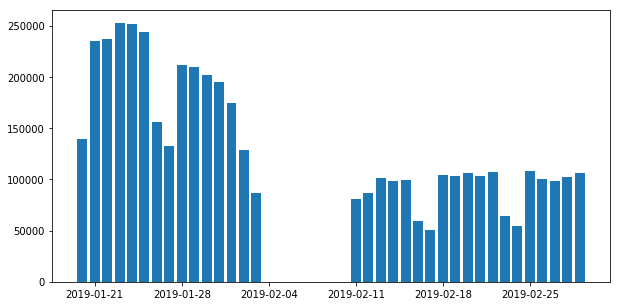

In [16]:
common_date = np.sum(table)
common_datetime = [pd.to_datetime(i).date() for i in np.array(table.columns)]
plt.figure(figsize = (10 , 5))
plt.bar(common_datetime, np.array(common_date))
plt.show()

In [17]:
table.head(2)

dt,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,...,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01
phone_no,,,,,,,,,,,,,,,,,,,,,
51379898,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
57047978,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X = np.array(table)[:, 0:-1]

a = np.where(np.array(table)[:, -1])
Y = np.zeros(len(table))
for i in a:
    Y[i] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)
print("training_set:", Counter(Y_train))
print("SMOTE", Counter(Y_smo))

training_set: Counter({0.0: 260246, 1.0: 19885})
SMOTE Counter({0.0: 260246, 1.0: 260246})


In [19]:
# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.864 (+/- 0.015)
F1-score of AdaBoost: 0.639 (+/- 0.004)


In [20]:
# testing
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_smo, Y_smo)
Y_prediction_rf = rf_clf.predict(X_test)
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

confusion_matrix of RadomForest is:
 [[161645  11814]
 [ 10314   2982]]


In [21]:
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[147122  26337]
 [  5777   7519]]


not to record the order number

In [22]:
X[X > 0] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)

In [23]:
# adaboost testing
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[138083  35376]
 [  4694   8602]]


split the weekend and weekday

In [24]:
date = pd.DataFrame(table.columns)
date = np.array(pd.to_datetime(date['dt']).dt.date)

weekday = []
for i in date:
    weekday.append(i.isoweekday())

weekday = np.array(weekday)

table.columns = weekday

In [25]:
table.columns

Int64Index([7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5, 6, 7,
            1, 2, 3, 4, 5, 6, 7, 1, 2, 3, 4, 5],
           dtype='int64')

In [26]:
# split the dataset
weekend = table.iloc[:, 0]
weekday = table.iloc[:,1:6]
for i in range(4):
    weekend = pd.concat([weekend, table.iloc[:, i * 7 + 6 : i * 7 + 8]], axis=1, join='outer')
    weekday = pd.concat([weekday, table.iloc[:, i * 7 + 8 : i * 7 + 13]], axis=1, join='outer')

##### weekday

In [34]:
dataset = np.array(weekday)
X = dataset[:, 0:-1]

a = np.where(dataset[:, -1])
Y = np.zeros(len(dataset))
for i in a:
    Y[i] = 1

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
smo = SMOTE(random_state = 10)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)

# training
# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.797 (+/- 0.001)
F1-score of AdaBoost: 0.632 (+/- 0.017)


In [28]:
# adaboost testing
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[138083  35376]
 [  4694   8602]]


In sum, there is no significant difference between different split of the dataset but sampling.  
Seeing from the f1-score, Randomforest works better.

In [36]:
from sklearn.externals import joblib
# imoprt
X = joblib.load('x.pkl')
Y = joblib.load('y.pkl')

smo = SMOTE(random_state = 100)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)

rf_clf = RandomForestClassifier(n_estimators=100)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
# adaboost
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)    
scores_AdaBoost = cross_val_score(AdaBoost_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("F1-score of AdaBoost: %0.3f (+/- %0.3f)" % (scores_AdaBoost.mean(), scores_AdaBoost.std() * 2))

F1-score of RadomForest: 0.836 (+/- 0.011)
F1-score of AdaBoost: 0.651 (+/- 0.012)


In [61]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_smo, Y_smo)
Y_prediction_rf = rf_clf.predict(X_test)
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

confusion_matrix of RadomForest is:
 [[158382  15077]
 [  9927   3369]]


#### tuning

In [40]:
# random forest
rf_clf = RandomForestClassifier(n_estimators=100, oob_score = False, min_samples_split = 2, min_samples_leaf = 1)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))

F1-score of RadomForest: 0.836 (+/- 0.010)


In [44]:
rf_clf = RandomForestClassifier(n_estimators=100, oob_score = True, min_samples_split = 2, min_samples_leaf = 1)
rf_clf.fit(X_smo, Y_smo)
Y_prediction_rf = rf_clf.predict(X_test)
print("AUC = ", metrics.roc_auc_score(Y_test, Y_prediction_rf))

AUC =  0.5823743034668375


In [52]:
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':range(50, 200, 10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8, max_features='sqrt', random_state=10), 
                       param_grid = param_test1, scoring='f1', cv=3)
gsearch1.fit(X_smo, Y_smo)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=8,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=20,
                                              min_samples_split=100,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=10,
                                  

In [53]:
print(gsearch1.best_params_)

{'n_estimators': 150}


best n_estimators is 150, then consider other parameters

In [66]:
param_test2 = {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=150, 
                                  min_samples_leaf=20, max_features='sqrt', oob_score=True, random_state=10),
                        param_grid = param_test2, scoring='f1', iid=False, cv=3)
gsearch2.fit(X_smo, Y_smo)

F:\PYTHON\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=20,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=None,
                                              oob_score=True, random_state=10,
                                  

In [67]:
print(gsearch2.best_params_)

{'max_depth': 13, 'min_samples_split': 50}


In [64]:
param_test3 = {'min_samples_leaf':range(10,60,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 150, max_depth=13, min_samples_split=50,
                                  max_features='sqrt', oob_score=True, random_state=10),
                        param_grid = param_test3, scoring='roc_auc',iid=False, cv=3)
gsearch3.fit(X_smo, Y_smo)

F:\PYTHON\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=13,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=None,
                                              oob_score=True, random_state=10,
                                    

In [65]:
print(gsearch3.best_params_)

{'min_samples_leaf': 10}


In [70]:
param_test4 = {'max_features':range(5, 24, 2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=150, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=10 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=3)
gsearch4.fit(X_smo, Y_smo)

F:\PYTHON\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=13,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=None,
                                              oob_score=True, random_state=10,
                                   

In [71]:
print(gsearch4.best_params_)

{'max_features': 5}


In [73]:
param_test5 = {'max_features':range(1, 6, 1)}
gsearch5 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=150, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=10 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='roc_auc',iid=False, cv=3)
gsearch5.fit(X_smo, Y_smo)

F:\PYTHON\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=13,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=50,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=150, n_jobs=None,
                                              oob_score=True, random_state=10,
                                   

In [74]:
print(gsearch5.best_params_)

{'max_features': 5}


In [75]:
# testing
rf_clf = RandomForestClassifier(n_estimators=150, max_depth=13, min_samples_split=50, max_features=5, oob_score=True, random_state=10)
rf_clf.fit(X_smo, Y_smo)
Y_prediction_rf = rf_clf.predict(X_test)
scores_rf = cross_val_score(rf_clf, X_smo, Y_smo, cv=3,scoring='f1')
print("F1-score of RadomForest: %0.3f (+/- %0.3f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("confusion_matrix of RadomForest is:\n",metrics.confusion_matrix(Y_test, Y_prediction_rf))

F1-score of RadomForest: 0.732 (+/- 0.002)
confusion_matrix of RadomForest is:
 [[140803  32656]
 [  5154   8142]]


nothing better than AdaBoost, try AdaBoost again

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
# imoprt
X = joblib.load('x.pkl')
Y = joblib.load('y.pkl')
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [34]:
# not to record the order number, only record whether to buy or not
X[X > 0] = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [35]:
smo = SMOTE(random_state = 0)
X_smo, Y_smo = smo.fit_sample(X_train, Y_train)

In [38]:
# adaboost testing
AdaBoost_clf = AdaBoostClassifier(n_estimators=10)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[138083  35376]
 [  4694   8602]]


In [41]:
# set n_estimators=15
AdaBoost_clf = AdaBoostClassifier(n_estimators=15)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[140127  33332]
 [  4934   8362]]


In [42]:
# set n_estimators=5
AdaBoost_clf = AdaBoostClassifier(n_estimators=5)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[144822  28637]
 [  5669   7627]]


In [45]:
# set n_estimators=5
AdaBoost_clf = AdaBoostClassifier(n_estimators=5)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[144822  28637]
 [  5669   7627]]


In [62]:
param_test1 = {'learning_rate':np.arange(0.1, 2, 0.1)}
gsearch1 = GridSearchCV(estimator = AdaBoostClassifier(random_state=10, n_estimators=10), 
                       param_grid = param_test1, scoring='f1', cv=3)
gsearch1.fit(X_smo, Y_smo)

GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=10,
                                          random_state=10),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [63]:
print(gsearch1.best_params_)

{'learning_rate': 1.3000000000000003}


In [64]:
# set n_estimators=5
AdaBoost_clf = AdaBoostClassifier(n_estimators=10, learning_rate=1.3)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[138925  34534]
 [  4809   8487]]


In [65]:
param_test2 = {'learning_rate':np.arange(0.1, 2, 0.1)}
gsearch2 = GridSearchCV(estimator = AdaBoostClassifier(random_state=10, n_estimators=10), 
                       param_grid = param_test1, scoring='roc_auc', cv=3)
gsearch2.fit(X_smo, Y_smo)

GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=10,
                                          random_state=10),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [66]:
print(gsearch2.best_params_)

{'learning_rate': 0.6}


In [67]:
AdaBoost_clf = AdaBoostClassifier(n_estimators=10, learning_rate=0.6)
AdaBoost_clf.fit(X_smo, Y_smo)
Y_prediction_AdaBoost = AdaBoost_clf.predict(X_test)
print("confusion_matrix of AdaBoost is:\n",metrics.confusion_matrix(Y_test, Y_prediction_AdaBoost))

confusion_matrix of AdaBoost is:
 [[140851  32608]
 [  4943   8353]]
